<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Класс-работы-с-данными" data-toc-modified-id="Класс-работы-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Класс работы с данными</a></span></li><li><span><a href="#Описание-модели" data-toc-modified-id="Описание-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание модели</a></span></li><li><span><a href="#Пример-использования-(ТЕСТ)" data-toc-modified-id="Пример-использования-(ТЕСТ)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Пример использования (ТЕСТ)</a></span></li><li><span><a href="#Предсказание-с-обученной-моделью" data-toc-modified-id="Предсказание-с-обученной-моделью-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Предсказание с обученной моделью</a></span></li></ul></div>

# Класс работы с данными

In [ ]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None


class DataProcess:
    """
    DataProcess class do all the data processing starting from
    all stations dataframe file
    DataProcess class expect to work with pandas.DataFrame

    Parameters
    ----------
    scaler : scaler function to use
        tested with sklearn.preprocessing.MinMaxScaler
    smoothing_window_size:  Int
        smooth data using SMA with window size = smoothing_window_size
    n_steps: Int
        Steps that corresponds to 2 days
    targets_columns: List
        List of column names that match the target values
    features_columns: List
        Columns names wich are not targets, but should be used
    time_index_column: Str
        Column with a valid datetime object
    object_id_column:
        Column name which corresponds to station unique id
    """
    def __init__(self, scaler, smoothing_window_size, n_steps, targets_columns,
                 features_columns, time_index_column, object_id_column):

        self.scaler = scaler
        self.smoothing_window_size = smoothing_window_size
        self.n_steps = n_steps
        self.targets_columns = targets_columns
        self.features_columns = features_columns
        self.time_index_column = time_index_column
        self.object_id_column = object_id_column

    def transform(self, data, skip, lq=0.001, hq=0.999):
        """
        Quantile transform data, and normalization

        Parameters
        ----------
        data : pandas.DataFrame
            data to process
        skip:  List
            list of columns skip during processing
        lq: Float
            lower quantile
        hq: Float
            higher quantile

        Returns
        ----------
        data, scalers : pandas.DataFrame, Dict[Objects]
            returns transformed data and fitted scalers 
        """
        # drop unused columns
        use_cols = [self.time_index_column, self.object_id_column] + \
            self.targets_columns + self.features_columns
        print(use_cols)
        data = data[use_cols]

        for col in list(data.select_dtypes(include=np.number)):
            if col not in skip:
                mx = data[col].quantile(hq)
                mn = data[col].quantile(lq)
                data[col] = data[col].where(data[col] < mx, mx)
                data[col] = data[col].where(data[col] > mn, mn)

        scalers = {}
        for col in self.targets_columns + self.features_columns:
            scaler = self.scaler()
            scaler.fit(data[col].values.reshape(-1, 1))
            scalers[col] = scaler
            data[col] = scaler.transform(data[col].values.reshape(-1, 1))

        return data, scalers

    def get_xy(self, prepared_data, keys_order):
        """
        Quantile transform data, and normalization

        Parameters
        ----------
        prepared_data : pandas.DataFrame
            transformed data or customly transformed data ready to split
        keys_order:  List
            order of keys to process, all keys shoudl be present at object_id_column values!


        Returns
        ----------
        X,Y,ONAMES : Tuple[List[array_like ... ], List[array_like ... ], List]
            X,Y partition suitable for keras.models fit and output names

        Note
        -------
        Use the same keys_order for all train, valid, and test subsets!
        Use the same targets order for all train, valid, and test subsets!
        """

        self.keys_order = keys_order
        objects_dict = self._get_xy(prepared_data, keys_order)
        X, Y, ONAMES = self._to_tensors(objects_dict, keys_order)
        return X, Y, ONAMES

    def _get_xy(self, data, keys_order):
        """
        Takes data for all stations in one pandas.DataFrame,
        Returns the X,Y partition for all stations as a dictionary

        Parameters
        ----------
        data : pandas.DataFrame
            Data with all stations by 20-minute records

        Returns
        -------
        BYSTATIONS : Dict[Str, Tuple[array_like, array_like]]
            Dictionary with keys corresponding to station names, values are typle with X and Y values

        Note
        -------
        All stations must have the exact number of steps, and must be time-aligned!
        """
        window = self.n_steps

        ind = self.n_steps // 2
        print(f'Inferring one day as : {ind} steps!')
        data = data.sort_values(by=self.time_index_column)

        BYSTATIONS = {}

        # through all stations
        for name in tqdm(keys_order):

            X, Y = [], []
            # filter rows by station
            station = data[data[self.object_id_column] == name]
            # sort by date from Jan to Dec
            station = station.sort_values(self.time_index_column)
            # replace 0 with nan
            station = station.replace(0, np.nan)
            # fill nan with mean on window 12, if possible
            # station = station.fillna(station.rolling(12, min_periods=1).mean())
            # see preapred data
            print(station[self.targets_columns].head())

            for win in station.rolling(window=window, min_periods=window):

                if win.shape[0] == window:
                    # smooth current
                    if self.smoothing_window_size > 1:
                        win[self.targets_columns] = win[
                            self.targets_columns].rolling(
                                window=self.smoothing_window_size,
                                min_periods=1).mean()

                    # split into 2 days
                    x = win.iloc[:ind, :][self.targets_columns +
                                          self.features_columns]
                    y = win.iloc[ind:, :][self.targets_columns]

                    # fillna if induced
                    x = x.fillna(x.mean()).fillna(0)
                    # y = y.fillna(y.mean()).fillna(0)

                    # append as numpy arrays
                    X.append(x.values)
                    Y.append(y.replace(0, np.nan).values)

            X, Y = np.array(X).astype(np.float16), np.array(Y).astype(
                np.float16)
            print(name, X.shape, Y.shape)
            BYSTATIONS[name] = (X, Y)

        return BYSTATIONS

    def _to_tensors(self, objects_dict, keys_order):
        """
        Takes the X,Y partition for all stations as a dictionary, 
        Returns X,Y tensors

        Parameters
        ----------
        D : Dict
            The X,Y partitioning for all stations as a dictionary,
            where keys correspond to individual stations (BYSTATIONS dict)
        key_order: List[Str] 
            Read order of keys from D
        targets : List
            List of column names that correspond to target values

        Returns
        -------
        X,Y,ONAMES : Tuple[List[array_like ... ], List[array_like ... ], List]
            X,Y partition suitable for keras.models fit and output names

        Note
        -------
        Use the same keys_order for all train, valid, and test subsets!
        Use the same targets order for all train, valid, and test subsets!
        """

        ONAMES = []  # Output Names
        X, Y = [], []

        for name in keys_order:

            ONAMES.extend([name + '_' + t for t in self.targets_columns])

            x, y = objects_dict[name]

            X.append(x)

            for i in range(len(self.targets_columns)):
                Y.append(y[:, :, i].reshape((y.shape[0], y.shape[1], 1)))

        return X, Y, ONAMES

# Описание модели

In [ ]:
import keras.backend as K
import tensorflow as tf
from tqdm.keras import TqdmCallback

models = tf.keras.models
layers = tf.keras.layers
utils = tf.keras.utils


class attention(layers.Layer):
    """
    It is a standard attention layer
    Calculates weights of LSTM output

    Note:
        For configuation settings see:
        https://www.tensorflow.org/guide/keras/custom_layers_and_models
    """
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):

        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return init * K.sum(output, axis=1)

    def get_config(self):
        return {'return_sequences': self.return_sequences}


class MosMIMO:
    """
    Multi-input multi-output mixed data model developed for 
    predicting ecolgical parameters 
    in multiple stations situated at one geo-cell about 25 km.

    Parameters
    ----------
    input_shape: Tuple[Int, Int] 
        input tensor shape.
        Example: (24, 6) - 24 hours, 6 parameters
    num_of_inputs: Int
        Example: 10 - ten stations
    input_names: List[Str]
        Example: IDs of stations or names. Should be unique!
    output_len: Int
        Example: 24 - net twenty four hours
    num_of_outputs: Int
        Example: 60 - 10*6  ten station with six parameters to predict
    output_names: List[Str]
        Example:  Tur_NO2, Tur_PM25 ... . Length(output_names) =  Length(utput_len)

    Note
    -------

    """
    def __init__(self, input_shape, num_of_inputs, input_names, output_len,
                 num_of_outputs, output_names):
        self.input_shape = input_shape
        self.num_of_inputs = num_of_inputs
        self.input_names = input_names
        self.output_len = output_len
        self.num_of_outputs = num_of_outputs
        self.output_names = output_names

    def get_model(self,
                  lstm_activation='relu',
                  num_of_layers=1,
                  num_of_hidden_units=96,
                  dropout=0.5,
                  recurrent_dropout=0.5,
                  optimizer='adam',
                  loss='mse'):
        """

        """
        inputs = []
        for i in range(self.num_of_inputs):
            inputs.append(
                layers.Input(shape=self.input_shape, name=self.input_names[i]))

        X = []
        for i in range(self.num_of_inputs):

            # Stacked input BLSTM
            inp = layers.Bidirectional(
                layers.LSTM(num_of_hidden_units,
                            activation=lstm_activation,
                            return_sequences=True,
                            dropout=dropout,
                            recurrent_dropout=recurrent_dropout))(inputs[i])

            for _ in range(num_of_layers):
                inp = layers.Bidirectional(
                    layers.LSTM(num_of_hidden_units,
                                activation=lstm_activation,
                                return_sequences=True,
                                dropout=dropout,
                                recurrent_dropout=recurrent_dropout))(inp)

            inp = layers.Bidirectional(
                layers.LSTM(num_of_hidden_units,
                            activation=lstm_activation,
                            dropout=dropout,
                            recurrent_dropout=recurrent_dropout))(inp)

            # encoder
            inp = layers.RepeatVector(self.output_len)(inp)
            inp = layers.Bidirectional(
                layers.LSTM(num_of_hidden_units,
                            activation=lstm_activation,
                            return_sequences=True,
                            dropout=dropout,
                            recurrent_dropout=recurrent_dropout))(inp)
            # attention
            #inpa = attention()([inputs[i], inp])
            inpa = layers.Attention(use_scale=True)([inputs[i], inp])
            #inp = layers.concatenate([inp, inpa], axis=-1)
            X.append(inpa)

        # all stations inforamtion
        out = layers.concatenate(X, axis=-1)

        # all stations output
        outputs = []
        for i in range(self.num_of_outputs):
            outputs.append(
                layers.TimeDistributed(
                    layers.Dense(1),
                    name=self.output_names[i])(out))  # need a relu!

        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=optimizer, loss=loss)

        print(model.summary())

        return model

# Пример использования (ТЕСТ)

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from tqdm.auto import tqdm
import pandas as pd
import os
from transliterate import translit
!pip install transliterate


# Соединим данные со всех станций в один датафрейм
# Аггрегируем данные за 1 час для каждой станции
path = '01_данные станций/'

df = pd.DataFrame()

for file in tqdm(os.listdir(path)):
    if '.xlsx' in file:
        if df.empty:
            d = pd.read_excel(path + file)
            d['Дата и время'] = pd.to_datetime(
                d['Дата и время'], format='%d/%m/%Y %H:%M')
            d = d.dropna(subset=['Дата и время'])
            d['Месяц'] = d['Дата и время'].dt.month
            d['День'] = d['Дата и время'].dt.day
            d['Час'] = d['Дата и время'].dt.hour
            d['Дата и время'] = pd.to_datetime('2020' + '-' +
                                               d['Месяц'].astype('int').astype('str') + '-' +
                                               d['День'].astype('int').astype('str') + ' ' +
                                               d['Час'].astype('int').astype('str') + ":0:0", format='%Y-%m-%d %H')
            d = d.sort_values(by='Дата и время')
            d = d.set_index('Дата и время').loc['2020-01-10':]
            d["Cтанция"] = file.replace('.xlsx', '')
            df = d
        else:
            d = pd.read_excel(path + file)
            d['Дата и время'] = pd.to_datetime(
                d['Дата и время'], format='%d/%m/%Y %H:%M')
            d = d.dropna(subset=['Дата и время'])
            d['Месяц'] = d['Дата и время'].dt.month
            d['День'] = d['Дата и время'].dt.day
            d['Час'] = d['Дата и время'].dt.hour
            d['Дата и время'] = pd.to_datetime('2020' + '-' +
                                               d['Месяц'].astype('int').astype('str') + '-' +
                                               d['День'].astype('int').astype('str') + ' ' +
                                               d['Час'].astype('int').astype('str') + ":0:0", format='%Y-%m-%d %H')
            d = d.sort_values(by='Дата и время')
            d = d.set_index('Дата и время').loc['2020-01-10':]
            d["Cтанция"] = file.replace('.xlsx', '')
            df = df.append(d)

df = df.reset_index()
df = df.loc[:, (~df.columns.str.startswith('Unnamed')).tolist()]
df = df.fillna(0)
st = df['Cтанция'].unique()
st_code = list(map(lambda x: translit(x, 'ru', reversed=True)[:3], st))
print(dict(zip(st, st_code)))

df['Cтанция'] = df['Cтанция'].apply(
    lambda x: translit(x, 'ru', reversed=True)[:3])
df['Дата и время'] = pd.to_datetime(df['Дата и время'])
df = df.sort_values(by='Дата и время')


df = df.groupby(['Cтанция', 'Месяц', 'День', 'Час'],
                as_index=False,
                sort=False).mean()

df['Дата и время'] = pd.to_datetime('2020' + '-' +
                                    df['Месяц'].astype('int').astype('str') + '-' +
                                    df['День'].astype('int').astype('str') + ' ' +
                                    df['Час'].astype('int').astype('str') + ":0:0", format='%Y-%m-%d %H')


# Ветер останкино
gdd.download_file_from_google_drive(file_id='1EVyVMySRdydBdHms32iI7eF9QKt-ydgu',
                                    dest_path='./03_метео_Останкино.xls')

global_wind = pd.read_excel('03_метео_Останкино.xls', header=[1])
global_wind.columns = ['Дата и время', 'Направление ветра', 'Скорость ветра']
df = df.merge(global_wind, on='Дата и время')

df.head(10)

     |████████████████████████████████| 45 kB 2.9 MB/s 
Unzipping...Done.


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

{'Туристская': 'Tur', 'Шаболовка': 'Sha', 'Марьино': 'Mar', 'Академика Анохина': 'Aka', 'Спиридоновка': 'Spi', 'Останкино': 'Ost', 'Глебовская': 'Gle', 'Пролетарский проспект': 'Pro', 'Коптевский бул': 'Kop', 'Бутлерова': 'But'}


,Cтанция,Месяц,День,Час,CO,NO2,NO,PM10,PM2.5,-T-,| V |,_V_,Давление,Влажность,Осадки,PM25,Дата и время,Направление ветра,Скорость ветра
0,Tur,1,10,0,0.026667,0.018333,0.002000,0.007333,0.000000,2.266667,0.800000,228.333333,743.466667,71.666667,0.0,0.000,2020-01-10,290.0,3.4
1,Sha,1,10,0,0.173333,0.021133,0.001000,0.007667,0.000000,1.700000,0.300000,170.000000,746.900000,84.700000,0.0,0.000,2020-01-10,290.0,3.4
2,Pro,1,10,0,0.216667,0.000000,0.000000,0.007000,0.003667,1.933333,1.633333,208.333333,745.866667,79.900000,0.0,0.000,2020-01-10,290.0,3.4
3,Mar,1,10,0,0.000000,0.023033,0.000667,0.008000,0.000000,2.100000,0.466667,119.666667,749.666667,73.066667,0.0,0.000,2020-01-10,290.0,3.4
4,But,1,10,0,0.200000,0.000000,0.000000,0.000000,0.000000,2.433333,1.500000,135.333333,744.800000,68.333333,0.0,0.000,2020-01-10,290.0,3.4
5,Kop,1,10,0,0.100000,0.028667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,2020-01-10,290.0,3.4
6,Gle,1,10,0,0.126667,0.022967,0.002000,0.007000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.006,2020-01-10,290.0,3.4
7,Aka,1,10,0,0.100000,0.036667,0.001333,0.000000,0.000000,1.400000,0.000000,113.000000,747.133333,63.333333,0.0,0.000,2020-01-10,290.0,3.4
8,Ost,1,10,0,0.100000,0.021000,0.003333,0.008333,0.000000,1.766667,1.500000,156.666667,746.200000,74.333333,0.0,0.000,2020-01-10,290.0,3.4
9,Spi,1,10,0,0.200000,0.027000,0.001000,0.007333,0.006667,2.333333,0.666667,206.666667,746.566667,89.133333,0.0,0.000,2020-01-10,290.0,3.4


In [ ]:
df.corr()[['PM10', 'NO']]**2

,PM10,NO
Месяц,0.000001,0.025964
День,0.000031,0.003410
Час,0.001702,0.000904
CO,0.155951,0.394564
NO2,0.085432,0.221414
NO,0.074738,1.000000
PM10,1.000000,0.074738
PM2.5,0.007173,0.155359
-T-,0.016122,0.000001
| V |,0.019652,0.017494


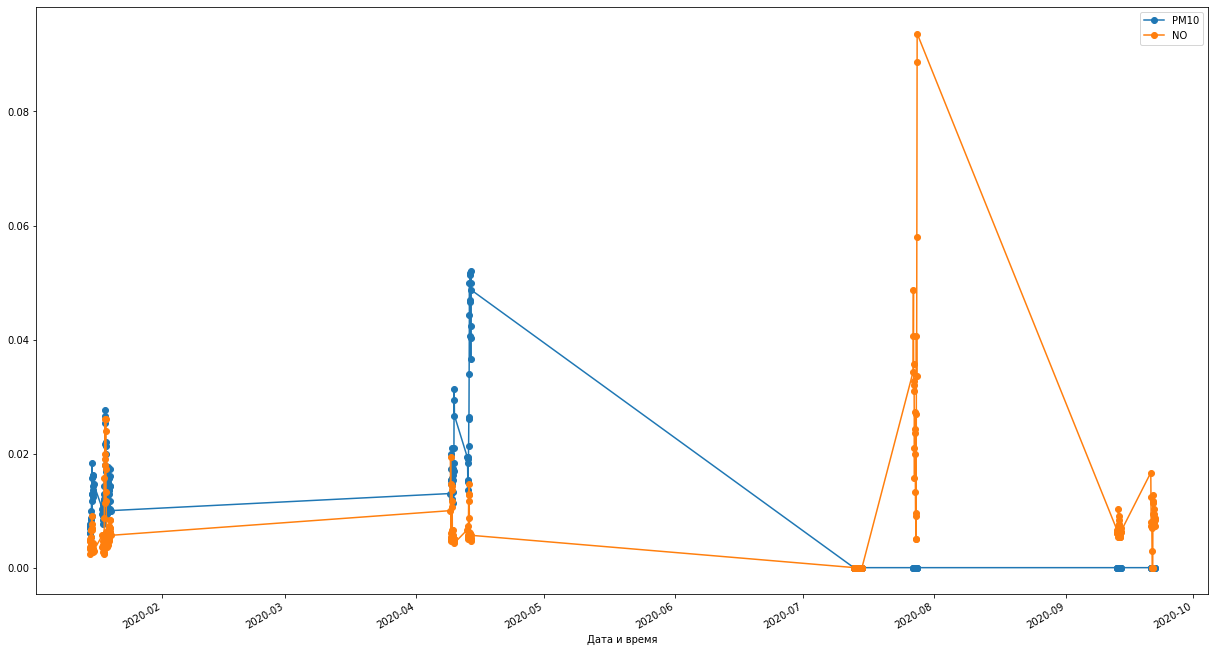

In [ ]:
dates = ['2020-01-15','2020-01-18','2020-01-19','2020-04-09','2020-04-13','2020-07-13','2020-07-14','2020-07-27','2020-09-13','2020-09-21']
ostankino = df[df['Cтанция'] == 'Ost']
ostankino_dates = ostankino[ostankino['Дата и время'].dt.date.astype('str').isin(dates)]

ostankino_dates = ostankino_dates[['Дата и время', 'PM10','NO']]
ostankino_dates = ostankino_dates.sort_values(by ='Дата и время')
ostankino_dates.set_index('Дата и время').plot(figsize = (21,12), marker='o')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

SCALER = MinMaxScaler
SMOOTHING_WINDOW_SIZE = 2
N_STEPS = 48
TARGETS_COLUMNS = ['NO2', 'PM25', 'PM2.5', 'PM10', 'NO',
                   'CO']  # Любое количество параметров
# 'Направление ветра', 'Скорость ветра', # Любое количество параметров
FEATURES_COLUMNS = [
    'Давление', 'Месяц', 'Час', 'Влажность', '-T-', '| V |', '_V_', 'Осадки'
]
TIME_INDEX_COLUMN = 'Дата и время'
OBJECT_ID_COLUMN = 'Cтанция'

dp = DataProcess(SCALER, SMOOTHING_WINDOW_SIZE, N_STEPS, TARGETS_COLUMNS,
                 FEATURES_COLUMNS, TIME_INDEX_COLUMN, OBJECT_ID_COLUMN)

In [ ]:
skip = ['Месяц', 'Час']
data, scalers = dp.transform(data=df.copy(), skip=skip)

['Дата и время', 'Cтанция', 'NO2', 'PM25', 'PM2.5', 'PM10', 'NO', 'CO', 'Давление', 'Месяц', 'Час', 'Влажность', '-T-', '| V |', '_V_', 'Осадки']


In [ ]:
data.head()

,Дата и время,Cтанция,NO2,PM25,PM2.5,PM10,NO,CO,Давление,Месяц,Час,Влажность,-T-,| V |,_V_,Осадки
0,2020-01-10,Aka,0.314286,0.000000,0.0,0.000000,0.004592,0.049973,0.967943,0.0,0.0,0.633333,0.293344,0.000000,0.321327,0.0
1,2020-01-10,But,0.000000,0.000000,0.0,0.000000,0.000000,0.099947,0.964920,0.0,0.0,0.683333,0.318817,0.306122,0.384834,0.0
2,2020-01-10,Gle,0.196857,0.141732,0.0,0.039279,0.006889,0.063299,0.000000,0.0,0.0,0.000000,0.258833,0.000000,0.000000,0.0
3,2020-01-10,Sha,0.181143,0.000000,0.0,0.043019,0.003444,0.086620,0.967641,0.0,0.0,0.847000,0.300740,0.061224,0.483412,0.0
4,2020-01-10,Kop,0.245714,0.000000,0.0,0.000000,0.000000,0.049973,0.000000,0.0,0.0,0.000000,0.258833,0.000000,0.000000,0.0


In [ ]:
scalers['NO2'].scale_, scalers['NO'].scale_

(array([8.57142857]), array([3.44431688]))

In [ ]:
train = data.set_index('Дата и время').loc[:'2020-10-01']
test = data.set_index('Дата и время').loc['2020-11-01':]

print(train.shape, test.shape)

(63840, 15) (14640, 15)


In [ ]:
keys_order = train['Cтанция'].unique()
keys_order

array(['Aka', 'But', 'Gle', 'Sha', 'Kop', 'Tur', 'Mar', 'Ost', 'Spi',
       'Pro'], dtype=object)

In [ ]:
X_train, Y_train, ONAMES = dp.get_xy(train, keys_order)
X_test, Y_test, ONAMES = dp.get_xy(test, keys_order)

Inferring one day as : 24 steps!


  0%|          | 0/10 [00:00<?, ?it/s]

                          NO2  PM25  PM2.5  PM10        NO        CO
Дата и время                                                        
2020-01-10 00:00:00  0.314286   NaN    NaN   NaN  0.004592  0.049973
2020-01-10 01:00:00  0.240000   NaN    NaN   NaN  0.002296  0.016658
2020-01-10 02:00:00  0.225714   NaN    NaN   NaN  0.001148  0.033316
2020-01-10 03:00:00  0.211429   NaN    NaN   NaN       NaN  0.033316
2020-01-10 04:00:00  0.194286   NaN    NaN   NaN  0.003444       NaN
Aka (6337, 24, 14) (6337, 24, 6)
                     NO2  PM25  PM2.5  PM10  NO        CO
Дата и время                                             
2020-01-10 00:00:00  NaN   NaN    NaN   NaN NaN  0.099947
2020-01-10 01:00:00  NaN   NaN    NaN   NaN NaN  0.099947
2020-01-10 02:00:00  NaN   NaN    NaN   NaN NaN  0.066631
2020-01-10 03:00:00  NaN   NaN    NaN   NaN NaN  0.066631
2020-01-10 04:00:00  NaN   NaN    NaN   NaN NaN  0.083289
But (6337, 24, 14) (6337, 24, 6)
                          NO2      PM25  PM2.

  0%|          | 0/10 [00:00<?, ?it/s]

                          NO2  PM25     PM2.5  PM10        NO  CO
Дата и время                                                     
2020-11-01 00:00:00  0.255714   NaN  0.369863   NaN  0.040184 NaN
2020-11-01 01:00:00  0.236000   NaN  0.321918   NaN  0.026406 NaN
2020-11-01 02:00:00  0.212857   NaN  0.273973   NaN  0.010333 NaN
2020-11-01 03:00:00  0.187429   NaN  0.267123   NaN  0.004592 NaN
2020-11-01 04:00:00  0.167143   NaN  0.267123   NaN  0.006889 NaN
Aka (1417, 24, 14) (1417, 24, 6)
                          NO2  PM25     PM2.5  PM10        NO        CO
Дата и время                                                           
2020-11-01 00:00:00  0.310857   NaN  0.356164   NaN  0.067738  0.099947
2020-11-01 01:00:00  0.273143   NaN  0.308219   NaN  0.027555  0.049973
2020-11-01 02:00:00  0.257429   NaN  0.273973   NaN  0.017222  0.049973
2020-11-01 03:00:00  0.217143   NaN  0.267123   NaN  0.006889  0.049973
2020-11-01 04:00:00  0.189143   NaN  0.267123   NaN  0.005741  0.049973
B

In [ ]:
Y_train[0]

array([[[0.4443],
        [0.463 ],
        [0.497 ],
        ...,
        [0.603 ],
        [0.617 ],
        [0.5913]],

       [[0.4536],
        [0.48  ],
        [0.52  ],
        ...,
        [0.61  ],
        [0.6045],
        [0.613 ]],

       [[0.4668],
        [0.5   ],
        [0.5327],
        ...,
        [0.607 ],
        [0.6084],
        [0.602 ]],

       ...,

       [[0.297 ],
        [0.3   ],
        [0.302 ],
        ...,
        [0.3467],
        [0.479 ],
        [0.562 ]],

       [[0.2986],
        [0.301 ],
        [0.302 ],
        ...,
        [0.4128],
        [0.5205],
        [0.549 ]],

       [[0.2998],
        [0.3015],
        [0.3022],
        ...,
        [0.4666],
        [0.5347],
        [0.5024]]], dtype=float16)

In [ ]:
ONAMES[:10]

['Aka_NO2',
 'Aka_PM25',
 'Aka_PM2.5',
 'Aka_PM10',
 'Aka_NO',
 'Aka_CO',
 'But_NO2',
 'But_PM25',
 'But_PM2.5',
 'But_PM10']

In [ ]:
INPUT_SHAPE = (X_train[0].shape[1], X_train[0].shape[2]) # 24 hours and x features
NUM_OF_INPUTS = len(X_train) # number of stations
INPUT_NAMES = keys_order
OUTPUT_LEN = Y_train[1].shape[1]
NUM_OF_OUTPUTS = len(ONAMES)
OUTPUT_NAMES = ONAMES

mm = MosMIMO(INPUT_SHAPE, NUM_OF_INPUTS, INPUT_NAMES, OUTPUT_LEN, NUM_OF_OUTPUTS, OUTPUT_NAMES)

In [ ]:
def mse_nan(y_true, y_pred):
    masked_true = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_true)
    masked_pred = tf.where(tf.math.is_nan(y_true), tf.zeros_like(y_true), y_pred)
    return K.max(K.square(masked_pred - masked_true), axis=-1)

In [ ]:
LSTM_ACTIVATION='relu'
NUM_OF_LAYERS = 0
NUM_OF_HIDDEN_UNITS = 32
DROPOUT=0.4
RECURRENT_DROPOUT=0.4
OPTIMIZER='sgd'# adam'
LOSS=mse_nan#'mse'

model = mm.get_model(LSTM_ACTIVATION, NUM_OF_LAYERS, NUM_OF_HIDDEN_UNITS, DROPOUT, RECURRENT_DROPOUT, OPTIMIZER, LOSS)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aka (InputLayer)                [(None, 24, 14)]     0                                            
__________________________________________________________________________________________________
But (InputLayer)                [(None, 24, 14)]     0                                            
__________________________________________________________________________________________________
Gle (InputLayer)                [(None, 24, 14)]     0                                            
__________________________________________________________________________________________________
Sha (InputLayer)                [(None, 24, 14)]     0                                            
____________________________________________________________________________________________

In [ ]:
# utils.plot_model(model, "model.png", show_shapes=True, rankdir='LR')

In [ ]:
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
history = model.fit(X_train,Y_train,
                    epochs=10, 
                    batch_size=128,
                    callbacks=[TqdmCallback(), lrs],
                    shuffle=True,
                    validation_split=0.3, 
                    verbose=0)  # , val_loss=0.617, nan? sup has no derivative?

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

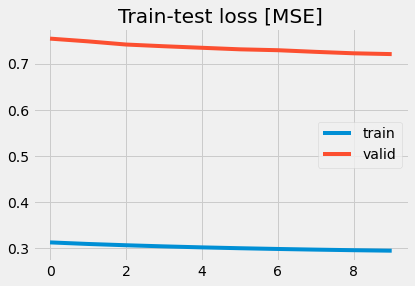

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Train-test loss [MSE]')
plt.legend()

In [ ]:
model.save('AbsMIMO.h5')
model = models.load_model('AbsMIMO.h5', custom_objects={'attention': attention, 'mse_nan':mse_nan})

In [ ]:
import pickle

with open('SCALERS', 'wb') as f:
    pickle.dump(scalers, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('OUTPUT_NAMES', 'wb') as f:
    pickle.dump(OUTPUT_NAMES, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('INPUT_SHAPE', 'wb') as f:
    pickle.dump(INPUT_SHAPE, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('INPUT_NAMES', 'wb') as f:
    pickle.dump(INPUT_NAMES, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def get_mape(tr, pr):
    """
    Median Absolute Pecentage Error

    Parameters
    ----------
    tr : array_like
        y_ture
    pr : array_like
        y_predicted

    Returns
    -------
    mape : Float
    """
    if len(np.unique(tr)) == 1: # all values are the same in y_true (non present and filled with same number)
        return 0
    tr += 0.0000001  # not 0, otherwise -> inf
    mape = np.median(np.abs((tr - pr) / tr)) # median because it is unstable
    if tr.sum() > 0:
        return min(100, mape * 100) # its mostly ok, but when it is not its exponential, due to the missing data
    else:
        return 0

In [ ]:
mnday = min([x.shape[0] for x in X_test])

for st in range(len(X_test)):
    X_test[st] = X_test[st][:mnday,:,:]

In [ ]:
PPREDICTED =  model.predict(X_test)

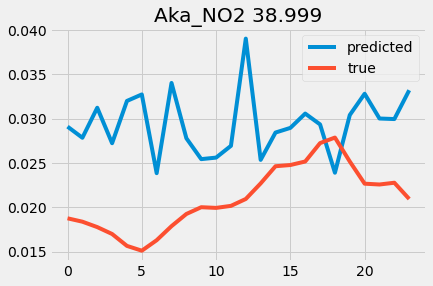

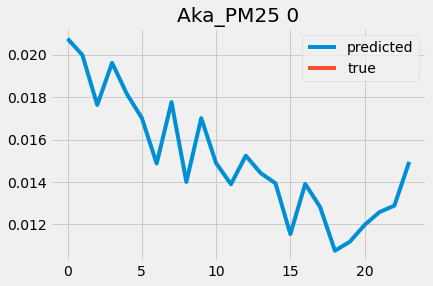

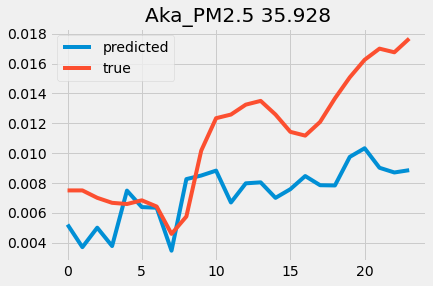

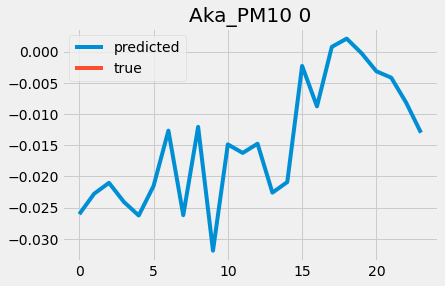

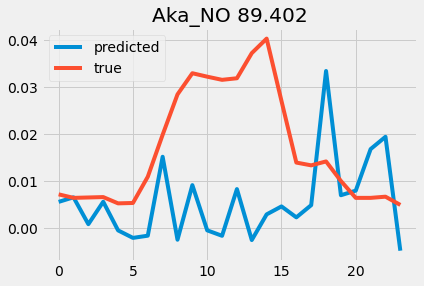

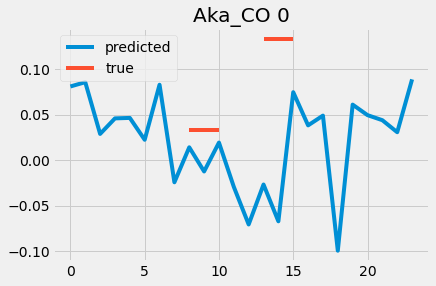

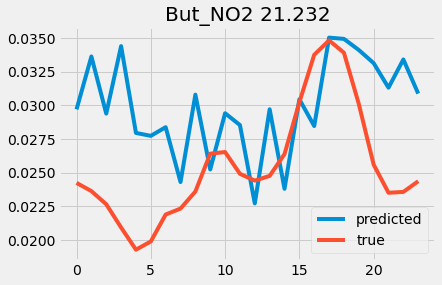

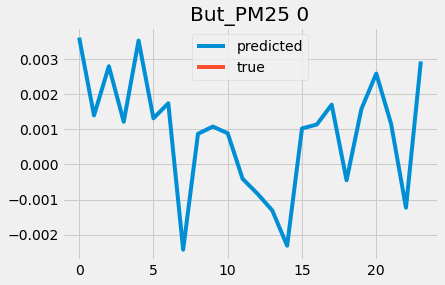

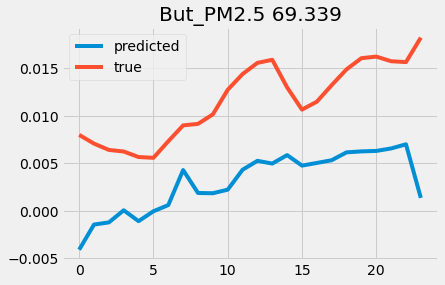

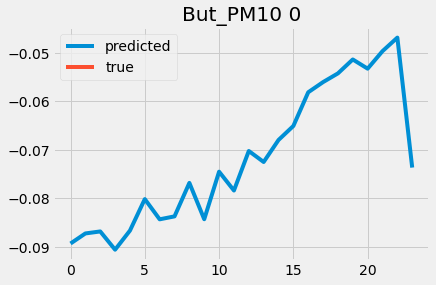

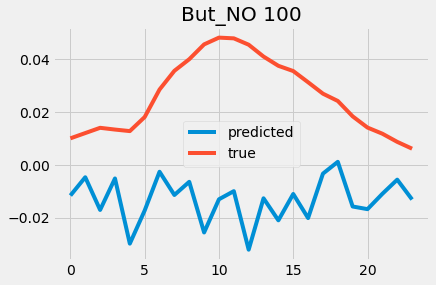

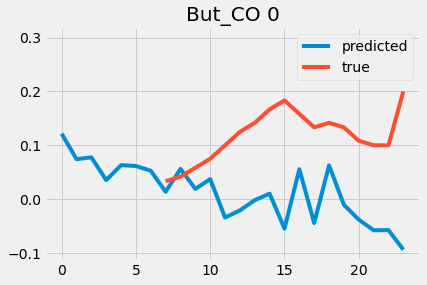

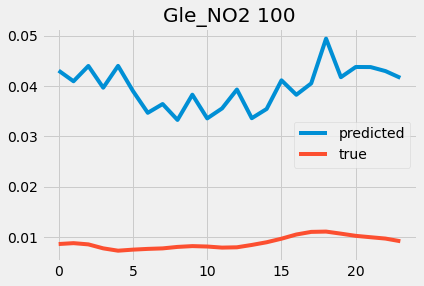

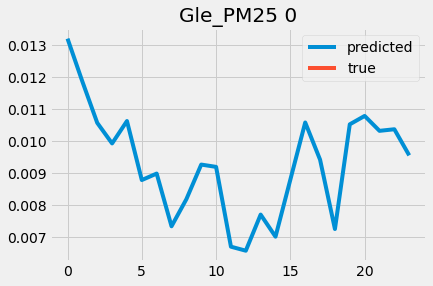

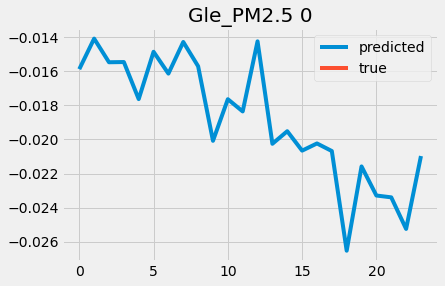

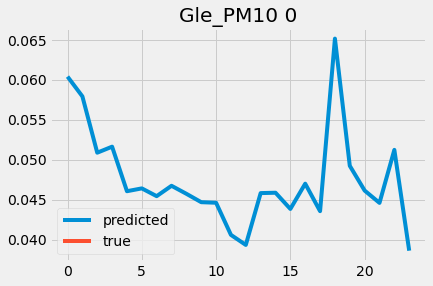

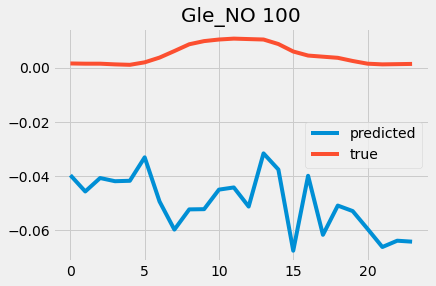

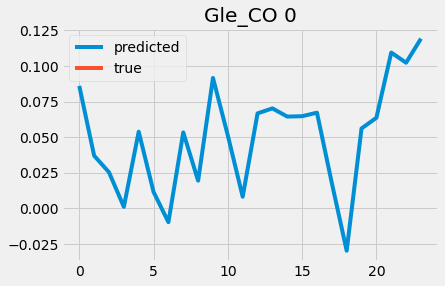

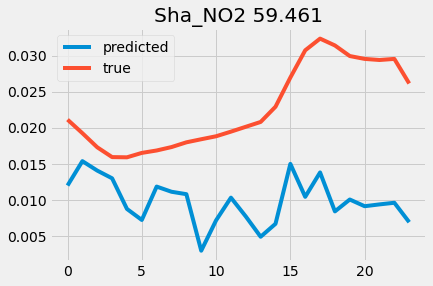

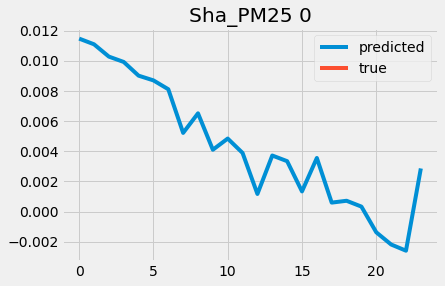

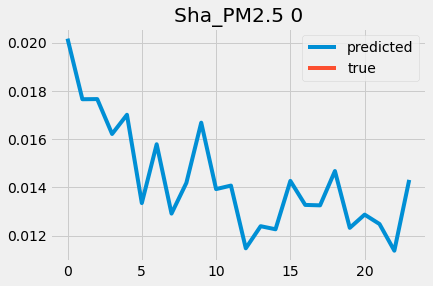

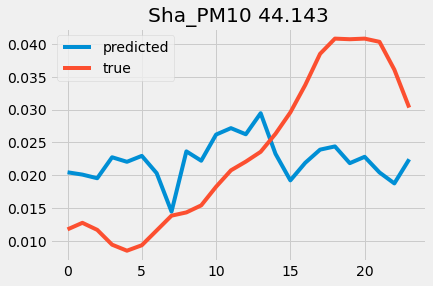

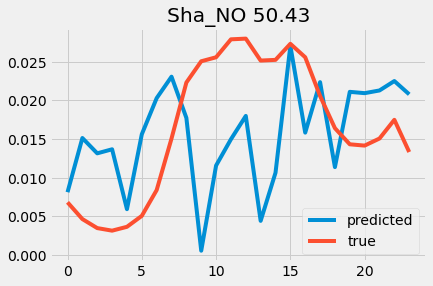

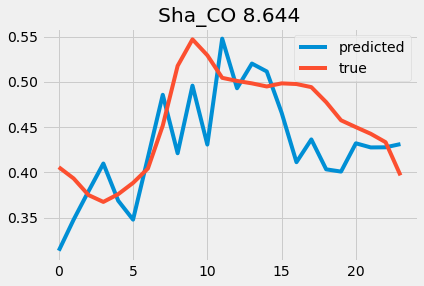

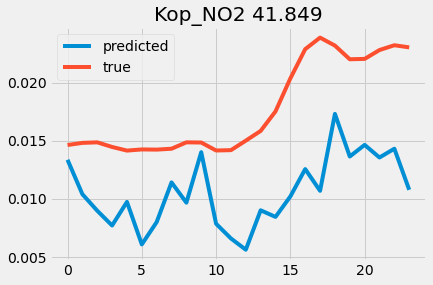

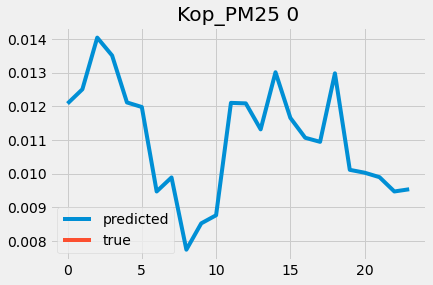

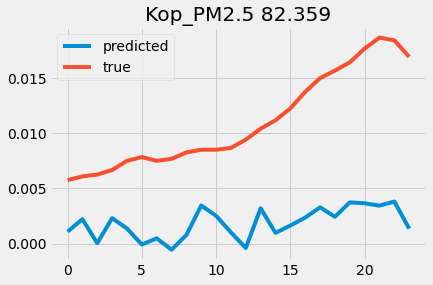

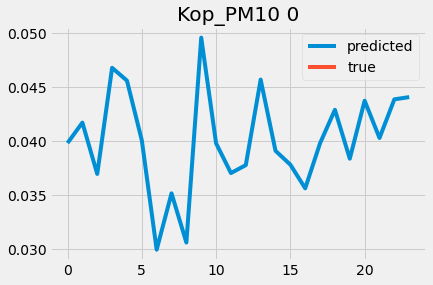

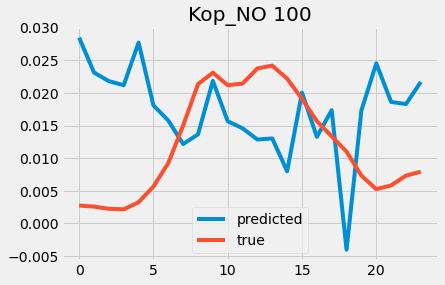

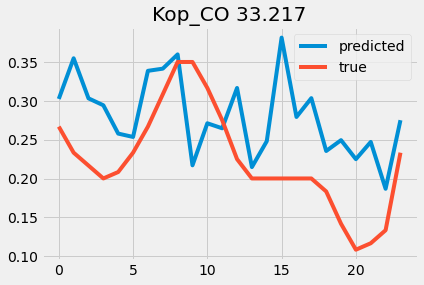

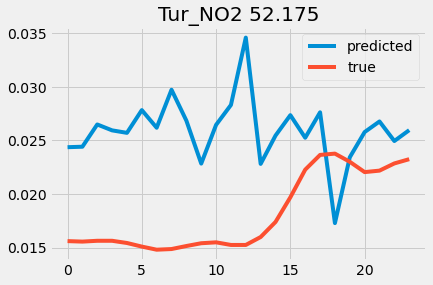

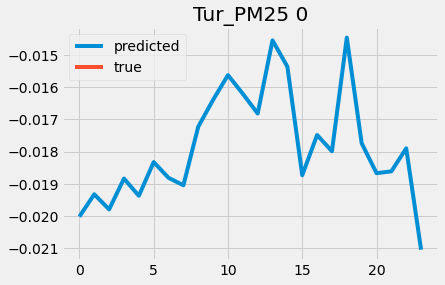

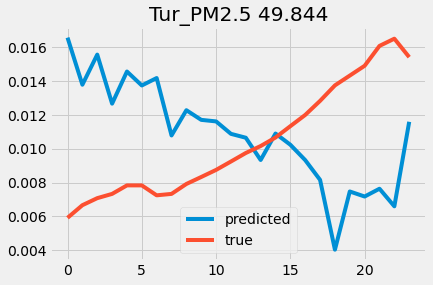

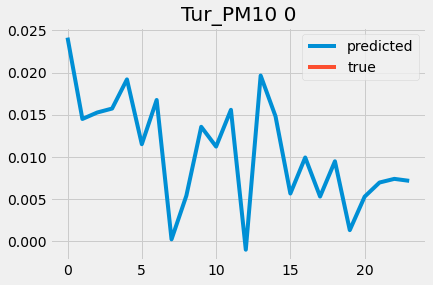

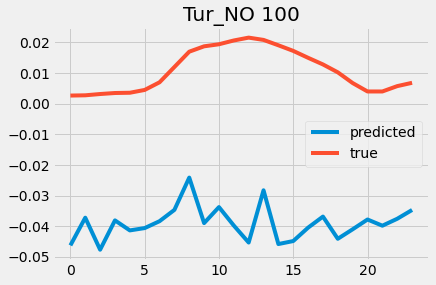

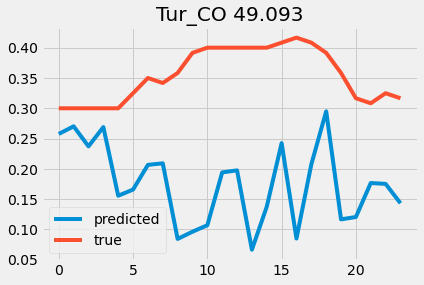

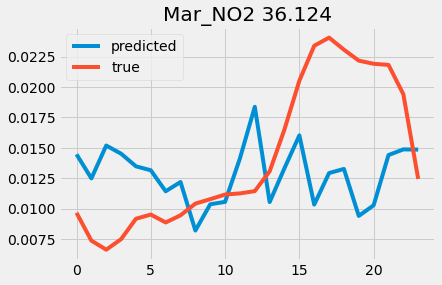

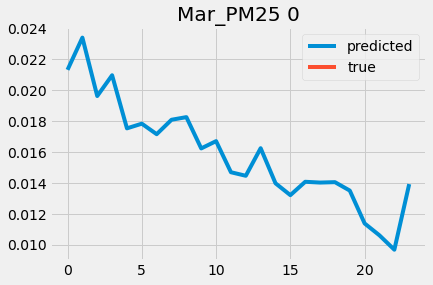

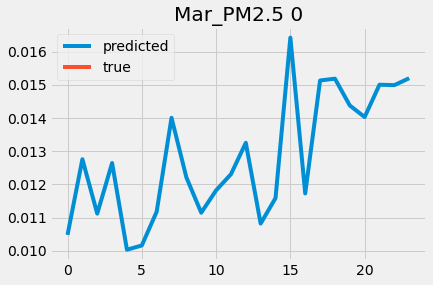

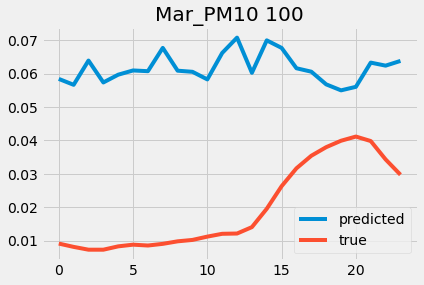

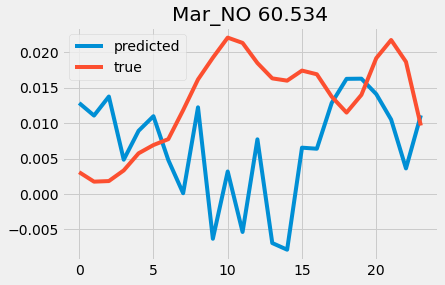

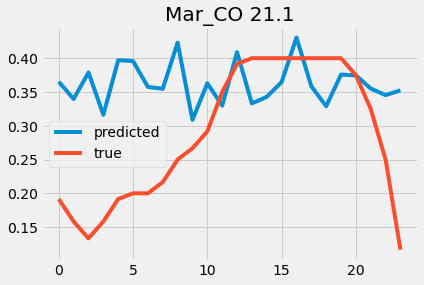

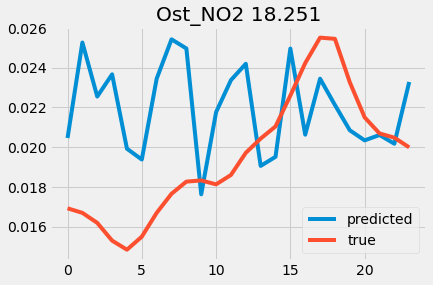

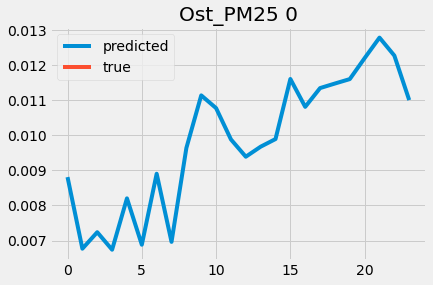

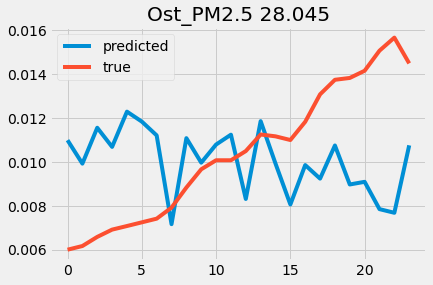

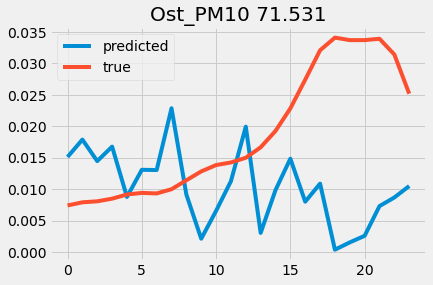

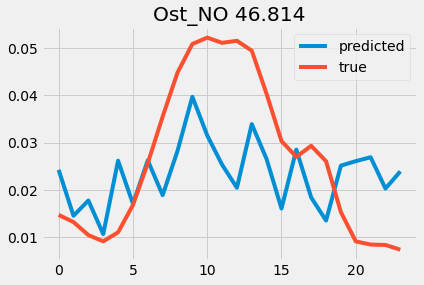

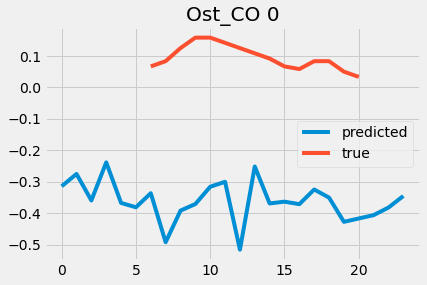

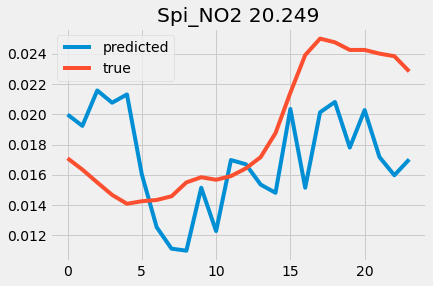

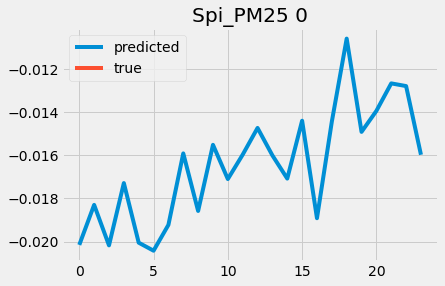

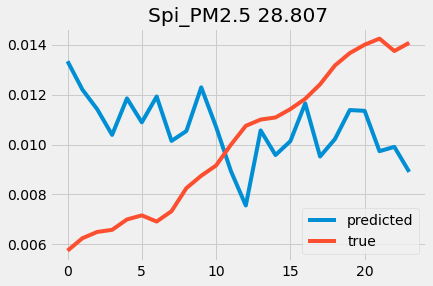

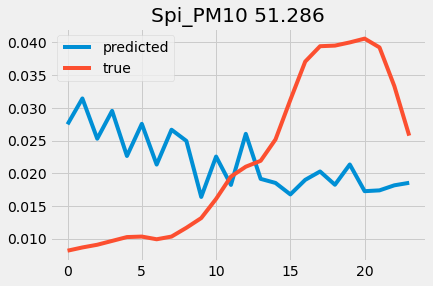

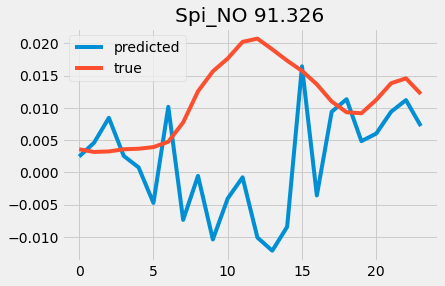

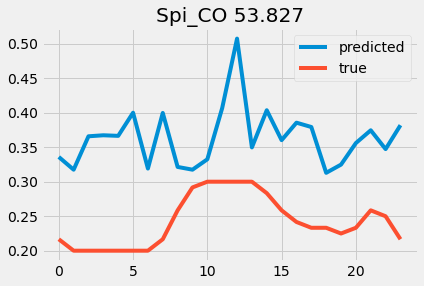

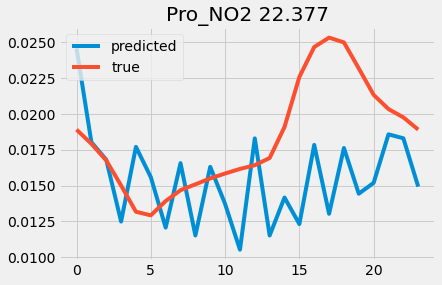

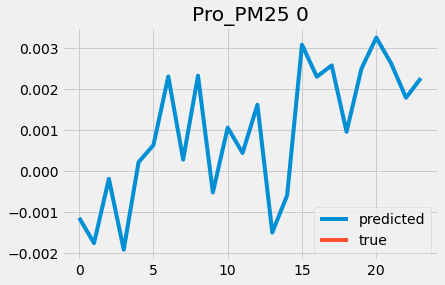

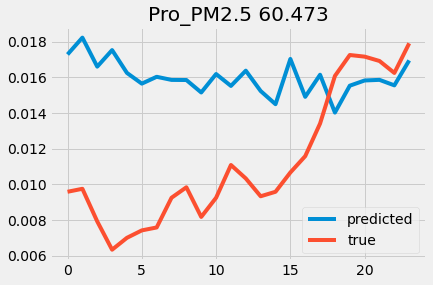

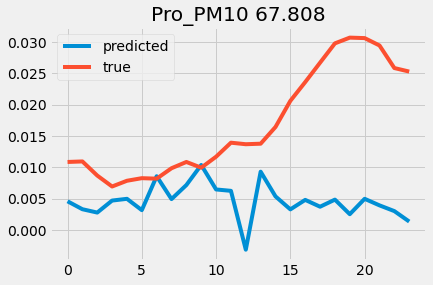

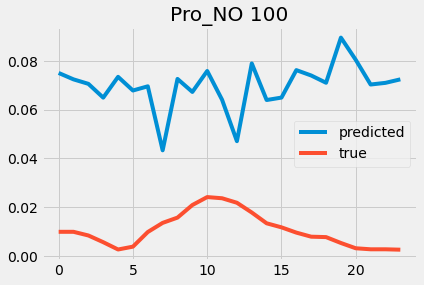

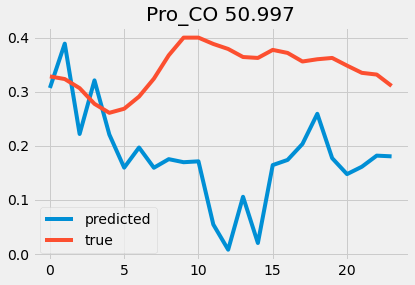

In [ ]:
for i in range(60):
    name = ONAMES[i]
    name = name.split('_')[-1]
    sc = scalers[name]

    pp = sc.inverse_transform(PPREDICTED[i][1,:,-1].reshape(-1, 1)) # 0 for the t0
    tt = sc.inverse_transform(Y_test[i][1].reshape(-1, 1)) # 0 for the t0

    plt.plot(pp, label='predicted')
    plt.plot(tt, label='true')
    mape = get_mape(tt, pp)
    plt.title(f'{ONAMES[i]} {round(mape,3)}')
    plt.legend()
    plt.show()

In [ ]:
ERRORS = []
for day in tqdm(range(Y_test[0].shape[0])):
    for parameter in range(60):
        name = ONAMES[parameter]
        name = name.split('_')[-1]
        sc = scalers[name]

        pp = sc.inverse_transform(PPREDICTED[parameter][day,:,-1].reshape(-1, 1))
        tt = sc.inverse_transform(Y_test[parameter][day].reshape(-1, 1))
        
        mape = get_mape(tt, pp)
        ERRORS.append(mape)

  0%|          | 0/1417 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Error on test +/-18.0%')

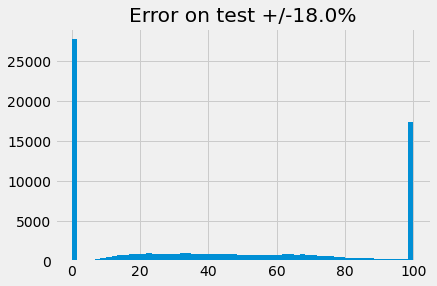

In [ ]:
plt.hist(ERRORS, bins=60);
plt.title(f'Error on test +/-{np.round(np.median(ERRORS)/2)}%')

# Предсказание с обученной моделью

In [ ]:
import keras.backend as K
import tensorflow as tf
import numpy as np


models = tf.keras.models
layers = tf.keras.layers
utils = tf.keras.utils

DN = {'Туристская': 'Tur', 
      'Академика Анохина': 'Aka', 
      'Останкино': 'Ost', 
      'Марьино': 'Mar', 
      'Пролетарский проспект': 'Pro', 
      'Бутлерова': 'But', 
      'Глебовская': 'Gle', 
      'Спиридоновка': 'Spi', 
      'Шаболовка': 'Sha', 
      'Коптевский бул': 'Kop'}

ND = {v:k for k,v in DN.items()}


class attention(layers.Layer):
    """
    It is a standard attention layer
    Calculates weights of LSTM output

    Note:
        For configuation setting see:
        https://www.tensorflow.org/guide/keras/custom_layers_and_models
    """
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):

        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

    def get_config(self):
        return {'return_sequences': self.return_sequences}

class Model:
    """
    Prediction class

    Parameters
    ----------
    model_name : Str
         path to tensorflow.keras model to load
    """
    def __init__(self, model_name = 'AbsMIMO.h5', output_names=None, scalers=None):
        self.model = models.load_model(model_name, custom_objects={'attention': attention, 'mse_nan':mse_nan})
        self.output_names = output_names
        self.scalers = scalers

    def _name_prediction(self, P):
        if not self.output_names:
            self.output_names = list(range(P))
        named_predictions = {k:v.flatten() for k,v in zip(self.output_names, P)}
        return named_predictions

    def _rescale(self, P):
        for k,v in P.items():
            name = k.split('_')[-1]
            P[k] = self.scalers[name].inverse_transform(v.reshape(-1, 1))
        return P
    def predict(self, X):
        prediction = self.model.predict(X)
        prediction = self._name_prediction(prediction)
        prediction = self._rescale(prediction)
        return prediction



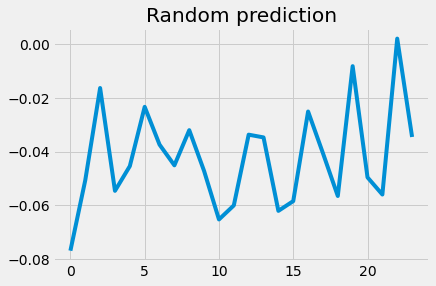

In [ ]:
import pickle

with open('SCALERS', 'rb') as handle:
    SCALERS = pickle.load(handle)

with open('OUTPUT_NAMES', 'rb') as handle:
    OUTPUT_NAMES = pickle.load(handle)

with open('INPUT_NAMES', 'rb') as handle:
    INPUT_NAMES = pickle.load(handle)

with open('INPUT_SHAPE', 'rb') as handle:
    INPUT_SHAPE = pickle.load(handle)

m = Model('AbsMIMO.h5', OUTPUT_NAMES, SCALERS)



X = np.random.uniform(size = INPUT_SHAPE)
X = X.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1]))
X = [X for _ in range(len(INPUT_NAMES))]

P = m.predict(X)
plt.plot(P['Tur_NO2'])
plt.title('Random prediction');

"15, 18-19 января 2021 года, 9, 13 апреля, 13-14, 27 июля, 13 и 21 сентября. по каждому параметру по каждой станции, которые участвовали в разработке."

In [ ]:
# loading this test 2021 data

# https://drive.google.com/file/d/1Zx4QnN_5fk62718D00mSJJEz7Sh5duFr/view?usp=sharing
# https://drive.google.com/file/d/1Zx4QnN_5fk62718D00mSJJEz7Sh5duFr/view?usp=sharing
gdd.download_file_from_google_drive(file_id='1Zx4QnN_5fk62718D00mSJJEz7Sh5duFr',
                                    dest_path='./test_2021.csv')

test_2021 = pd.read_csv('test_2021.csv')

test_2021['Дата и время'] = pd.to_datetime(test_2021['Дата и время'], format='%Y-%m-%d %H' )

In [ ]:
test_2021.head()

,Cтанция,Месяц,День,Час,-T-,CO,NO,NO2,PM2.5,PM2.5.1,_V_,| V |,Влажность,Давление,Осадки,PM10,PM25,Дата и время
0,Aka,1,13,0,-10.1,0.433333,0.023667,0.036033,0.019333,NaN,240.000000,0.9,86.766667,747.8,0.0,NaN,NaN,2021-01-13
1,Tur,1,13,0,-10.4,0.500000,0.047667,0.047100,0.019333,NaN,18.666667,0.2,85.800000,749.8,0.0,NaN,NaN,2021-01-13
2,Sha,1,13,0,NaN,0.466667,0.056000,0.051267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-13
3,Ost,1,13,0,NaN,0.333333,0.032333,0.042667,0.015000,NaN,NaN,NaN,NaN,NaN,NaN,0.020,NaN,2021-01-13
4,Spi,1,13,0,NaN,0.266667,0.035000,0.034333,0.011000,NaN,NaN,NaN,NaN,NaN,NaN,0.024,NaN,2021-01-13


In [ ]:
test_2021, scalers2 = dp.transform(data=test_2021.copy(), skip=skip)

['Дата и время', 'Cтанция', 'NO2', 'PM25', 'PM2.5', 'PM10', 'NO', 'CO', 'Давление', 'Месяц', 'Час', 'Влажность', '-T-', '| V |', '_V_', 'Осадки']


In [ ]:
INPUT_NAMES, TARGETS_COLUMNS + FEATURES_COLUMNS

(array(['Aka', 'But', 'Gle', 'Sha', 'Kop', 'Tur', 'Mar', 'Ost', 'Spi',
        'Pro'], dtype=object),
 ['NO2',
  'PM25',
  'PM2.5',
  'PM10',
  'NO',
  'CO',
  'Давление',
  'Месяц',
  'Час',
  'Влажность',
  '-T-',
  '| V |',
  '_V_',
  'Осадки'])

In [ ]:
# 15 january by 14 january

In [ ]:
# 15 января 2021 года,
X = []
for station in INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-01-14']
    ts = ts[ts['Cтанция'] == station][TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:
        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        X.append(np.empty(shape=INPUT_SHAPE).reshape(
                (1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

In [ ]:
m = Model('AbsMIMO.h5', OUTPUT_NAMES, scalers2)

In [ ]:
jan15 = m.predict(X)

In [ ]:
# 18 января 2021 года,
X = []
for station in INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-01-17']
    ts = ts[ts['Cтанция'] == station][TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:

        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        print(station, ' is empty!')
        X.append(np.empty(shape=INPUT_SHAPE).reshape(
                (1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

jan18 = m.predict(X)

In [ ]:
# 19 января 2021 года,

X = []
for station in INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-01-18']
    ts = ts[ts['Cтанция'] == station][TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:

        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        print(station, ' is empty!')
        X.append(np.empty(shape=INPUT_SHAPE).reshape(
                (1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

jan19 = m.predict(X)

Aka  is empty!
But  is empty!
Mar  is empty!
Ost  is empty!


In [ ]:
# 9 апреля
X = []
for station in INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-04-8']
    ts = ts[ts['Cтанция'] == station][TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:
        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        print(station, ' is empty!')
        X.append(
            np.empty(shape=INPUT_SHAPE).reshape(
                (1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

apr9 = m.predict(X)

Aka  is empty!
But  is empty!


In [ ]:
# 13 апреля
X = []
for station in  INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-04-12']
    ts = ts[ts['Cтанция'] == station][ TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:
        
        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        print(station, ' is empty!')
        X.append(np.empty(shape=INPUT_SHAPE).reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

apr13 = m.predict(X)

In [ ]:
# 13 июля
X = []
for station in  INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-07-12']
    ts = ts[ts['Cтанция'] == station][ TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:
        
        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        print(station, ' is empty!')
        X.append(np.empty(shape=INPUT_SHAPE).reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

jul13 = m.predict(X)

In [ ]:
# 14 июля
X = []
for station in  INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-07-13']
    ts = ts[ts['Cтанция'] == station][ TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:
        
        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        print(station, ' is empty!')
        X.append(np.empty(shape=INPUT_SHAPE).reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

jul14 = m.predict(X)

Aka  is empty!
But  is empty!
Sha  is empty!
Tur  is empty!
Mar  is empty!
Ost  is empty!


In [ ]:
# 27 июля
X = []
for station in  INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-07-26']
    ts = ts[ts['Cтанция'] == station][ TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:
        
        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        print(station, ' is empty!')
        X.append(np.empty(shape=INPUT_SHAPE).reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

jul27 = m.predict(X)

In [ ]:
# 13 сентября
X = []
for station in  INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-09-12']
    ts = ts[ts['Cтанция'] == station][ TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:
        
        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        print(station, ' is empty!')
        X.append(np.empty(shape=INPUT_SHAPE).reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

sep13 = m.predict(X)

In [ ]:
# 21 сентября
X = []
for station in  INPUT_NAMES:
    ts = test_2021.set_index('Дата и время').loc['2021-09-20']
    ts = ts[ts['Cтанция'] == station][ TARGETS_COLUMNS + FEATURES_COLUMNS]
    if not ts.empty:
        
        X.append(ts.values.reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))
    else:
        print(station, ' is empty!')
        X.append(np.empty(shape=INPUT_SHAPE).reshape((1, INPUT_SHAPE[0], INPUT_SHAPE[1])))

sep21 = m.predict(X)

In [ ]:
SB = {'Академика Анохина': 'Aka', 'Останкино': 'Ost', 'Бутлерова': 'But', 'Глебовская': 'Gle', 'Туристская': 'Tur', 'Марьино': 'Mar', 'Спиридоновка': 'Spi', 'Пролетарский проспект': 'Pro', 'Коптевский бул': 'Kop', 'Шаболовка': 'Sha'}
SBR =  {v:k for k,v in SB.items()}

In [ ]:
from collections import  defaultdict
RESULT = defaultdict(lambda : []) 

DATES = ['15/01/21','18/01/21', '19/01/21', '09/04/21', '13/04/21','13/07/21', '14/07/21', '27/07/21', '13/09/21','21/09/21']
objects =[jan15,    jan18,      jan19,      apr9,       apr13,     jul13,      jul14,      jul27,      sep13,      sep21]

for date, res in zip(DATES, objects):
    d = pd.DataFrame()
    for k, v in res.items():
        name = SBR[k.split('_')[0]]
        name = f"{name} {k.split('_')[1]}"
        d[name] = v.flatten()
        d[name] = d[name].where(d[name]>0, np.nan) # for not present before 24h

    for name in SB.keys():
        dd = d.loc[:, d.columns.str.contains(name)]
        dd['Дата и время'] = date
        dd['Час'] = list(range(24))
        dd['Дата и время'] = dd['Дата и время'] + ' ' + dd['Час'].astype('str') + ':00:00'
        dd = dd.drop('Час', axis=1)
        dd = dd.T.rename(columns=dd.T.iloc[-1]).iloc[:-1,:]
        RESULT[name].append(dd.fillna(0))

In [ ]:
for name in RESULT.keys():
    RESULT[name] = pd.concat(RESULT[name], axis=1)

In [ ]:
RESULT['Академика Анохина'].shape

(6, 240)

In [ ]:
with pd.ExcelWriter('test_dates.xlsx') as writer: 
    for name in RESULT.keys():
        RESULT[name].to_excel(writer, sheet_name=name)

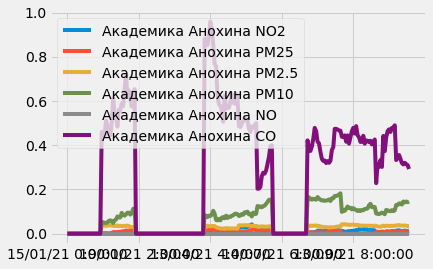

In [ ]:
RESULT['Академика Анохина'].T.plot()

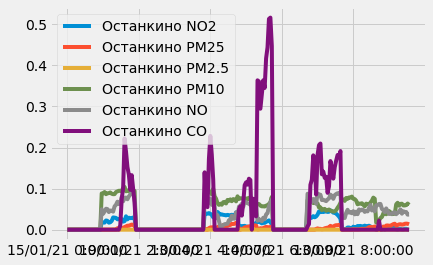

In [ ]:
RESULT['Останкино'].T.plot()